In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(12345)
plt.rcParams['figure.figsize'] = [12, 8]

1000


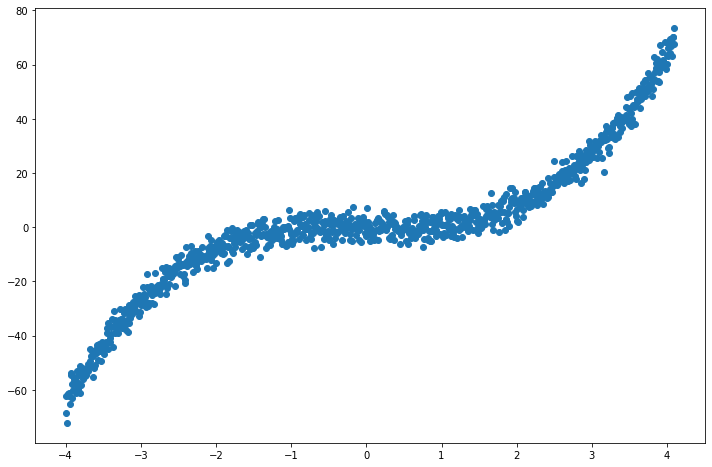

In [2]:
# Training set

batch_size = 256

xs = torch.linspace(-4., 4.1, 1000)
xs.unsqueeze_(1)

xs_train = xs #(xs-min(xs))/(max(xs)-min(xs)) # normalize -> 0 to 1
ys = xs ** 3 + torch.empty(xs.shape).normal_(mean=0,std=3.)

plt.scatter(xs, ys)
total_pts = len(xs)
print(total_pts)

In [3]:
# Functions

def batching(xs, ys, batch_size):
    total = len(xs)
    Xs, Ys = [], []
    
    a = np.arange(0,total)
    np.random.shuffle(a)
    
    count = 0
    for _ in range(int(total/batch_size)):
        if total-count > batch_size:
            Xs.append(xs[a[count:count+batch_size],:])
            Ys.append(ys[a[count:count+batch_size],:])
        else:
            Xs.append(xs[count:,:])
            Ys.append(ys[count:,:])
        count += batch_size
        
    return Xs, Ys

from torch.nn import Module
import torch.nn.functional as F

def NIG_NLL(y: torch.Tensor,
            gamma: torch.Tensor,
            nu: torch.Tensor,
            alpha: torch.Tensor,
            beta: torch.Tensor, reduction='mean'):
    twoBlambda = 2*beta*(1+nu)
    nll = 0.5*torch.log(np.pi/nu) - alpha*torch.log(twoBlambda) \
          + (alpha+0.5) * torch.log(nu*(y-gamma)**2 + twoBlambda) \
          + torch.lgamma(alpha)  \
          - torch.lgamma(alpha+0.5)
    
    return nll.mean()

def NIG_Reg(y, gamma, nu, alpha, reduction='mean'):
    error = (y - gamma).abs()
    evidence = 2. * nu + alpha
    return (error * evidence).mean()

def EvidentialRegression(y: torch.Tensor, evidential_output: torch.Tensor, lmbda=0.01, eps=0.01):
    gamma = evidential_output[0, :]
    nu = evidential_output[1, :]
    alpha = evidential_output[2, :]
    beta = evidential_output[3, :]

    loss_nll = NIG_NLL(y, gamma, nu, alpha, beta)
    loss_reg = NIG_Reg(y, gamma, nu, alpha)
    return (loss_nll + lmbda * (loss_reg - eps), loss_nll, loss_reg)

from torch import nn
from torch.nn import Module
import torch.nn.functional as F

# Neural Network
class BasicNetwork(torch.nn.Module):
    def __init__(self, n_in=1, n_tasks=1):
        super(BasicNetwork, self).__init__()
        self.l1 = torch.nn.Linear(n_in, 100)
        self.l2 = torch.nn.Linear(100, 100)
        self.l3 = torch.nn.Linear(100, 100)
        self.l4 = torch.nn.Linear(100, 100)
        self.l5 = DenseNormalGamma(100, 1)
        
    def forward(self, x):
        x = self.l1(x)
        x = torch.nn.functional.relu(x)
        x = self.l2(x)
        x = torch.nn.functional.relu(x)
        x = self.l3(x)
        x = torch.nn.functional.relu(x)
        x = self.l4(x)
        x = torch.nn.functional.relu(x)
        x = self.l5(x)
        return x

# NormalGamma Distribution
class DenseNormalGamma(Module):
    def __init__(self, n_input, n_out_tasks=1):
        super(DenseNormalGamma, self).__init__()
        self.n_in = n_input
        self.n_out = 4 * n_out_tasks
        self.n_tasks = n_out_tasks
        self.l1 = nn.Linear(self.n_in, self.n_out)

    def forward(self, x):
        x = self.l1(x)
        if len(x.shape) == 1:
            gamma, lognu, logalpha, logbeta = torch.split(x, self.n_tasks, dim=0)
        else:
            gamma, lognu, logalpha, logbeta = torch.split(x, self.n_tasks, dim=1)

        nu = F.softplus(lognu)
        alpha = F.softplus(logalpha) + 1.
        beta = F.softplus(logbeta)

        return torch.stack([gamma, nu, alpha, beta]).to(x.device)

In [4]:
# Plot

def plot():
    xs_hat = torch.linspace(-7, 7.1, 1000)
    xs_hat.unsqueeze_(1)

    xs_hat_test = xs_hat #(xs_hat-min(xs))/(max(xs)-min(xs))
    ys_hat = xs_hat ** 3

    y_hat, y_aleatoric, y_epistemic = [], [], []

    for i, x in enumerate(xs_hat_test):
        output = model(x)
        gamma, nu, alpha, beta = output
        gamma, nu, alpha, beta = gamma.item(), nu.item(), alpha.item(), beta.item()
        y_hat.append(gamma)
        try:
            y_aleatoric.append(np.sqrt(beta/(alpha-1)))
            y_epistemic.append(np.sqrt(beta/(alpha-1)/nu))

        except:
            y_aleatoric.append(0.)
            y_epistemic.append(0.)
            #print("step x x^3 gamma nu alpha beta")
            #print(i, x, x**3, gamma, nu, alpha, beta)

    y_hat = np.array(y_hat)
    y_aleatoric = np.array(y_aleatoric)
    y_epistemic = np.array(y_epistemic)
    
    # Plot
    plt.plot(xs_hat, y_hat, label='Prediction')
    plt.scatter(xs_hat, ys_hat, label='Original')
    plt.fill_between(xs_hat[:,0], y_hat-3*y_aleatoric, y_hat+3*y_aleatoric, alpha=0.7, label='Aleatoric')
    plt.fill_between(xs_hat[:,0], y_hat-3*y_epistemic, y_hat+3*y_epistemic, alpha=0.3, label='Epistemic')
    plt.axvline(-4, -150, 150, linestyle='--')
    plt.axvline(4, -150, 150, linestyle='--')
    plt.ylim((-150, 150))
    plt.legend()
    plt.show()

            Loss     NLL     REG
Step    0:  7.6697  7.2488 42.0961
Step  500:  2.6811  2.6336  4.7607


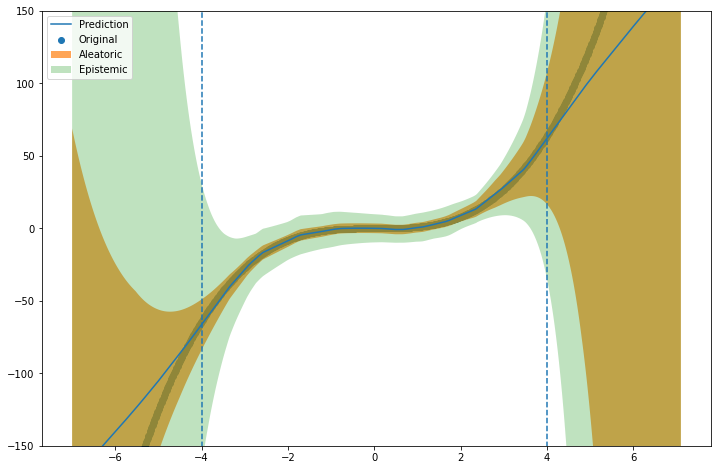

Step 1000:  2.7137  2.6626  5.1181


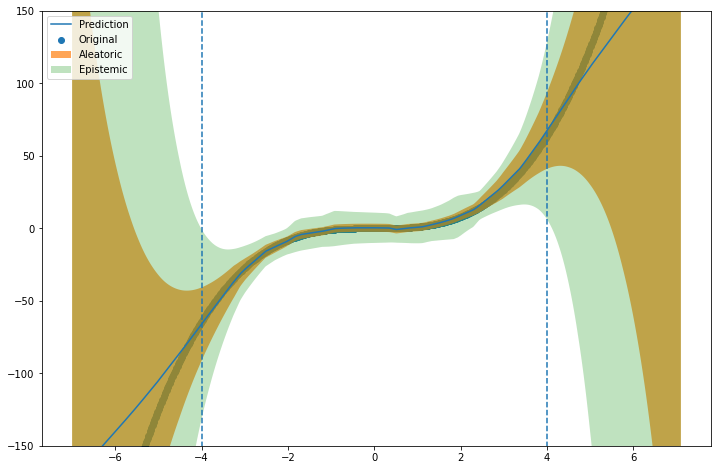

Step 1500:  2.5919  2.5441  4.7948


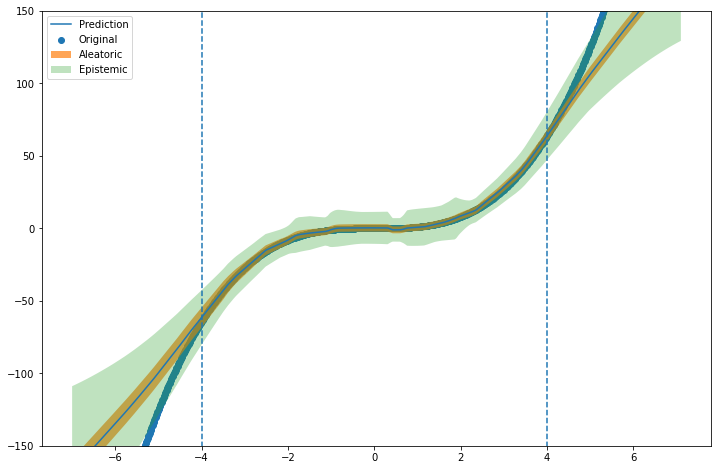

Step 2000:  2.6442  2.5885  5.5771


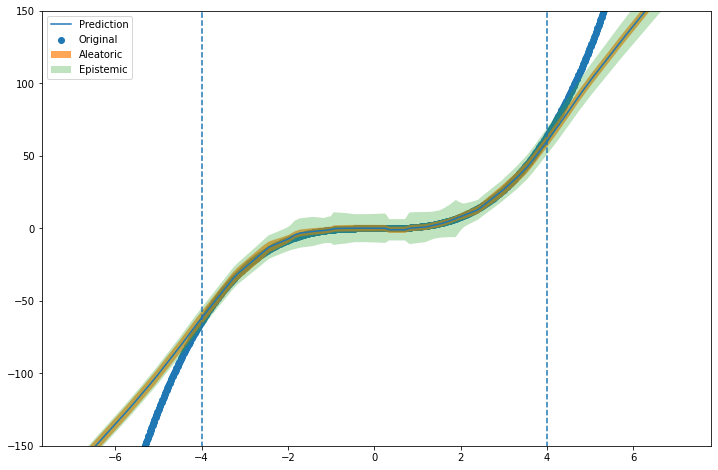

Step 2500:  2.7054  2.6550  5.0554


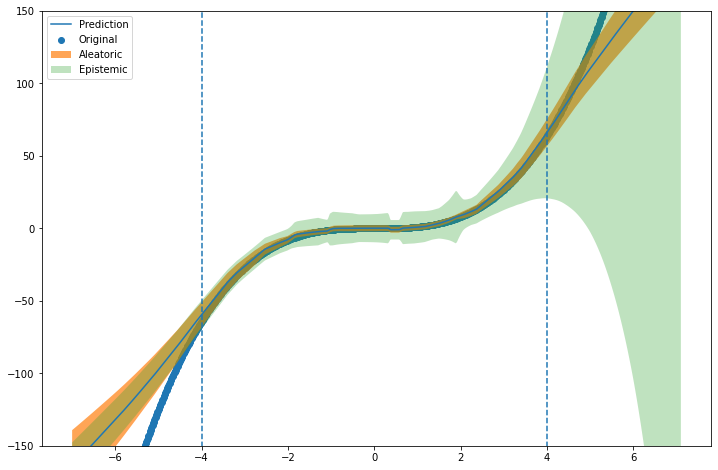

Step 3000:  2.5860  2.5377  4.8396


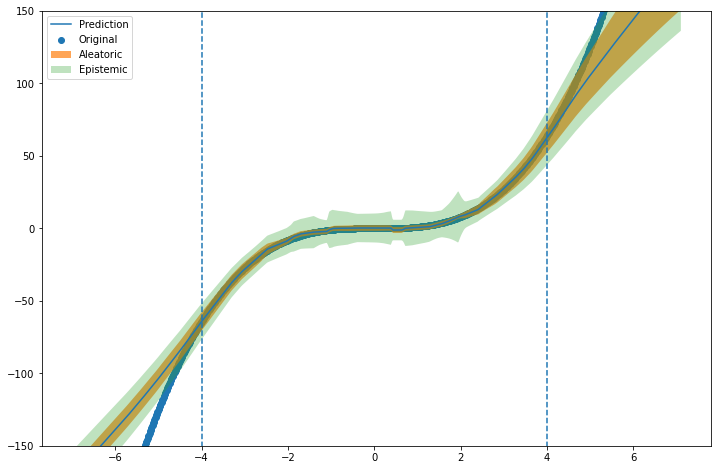

Step 3500:  2.6222  2.5738  4.8557


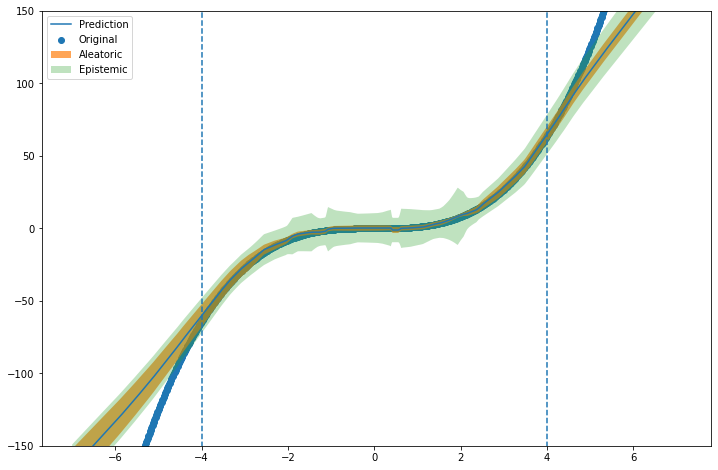

Step 4000:  2.5963  2.5503  4.6047


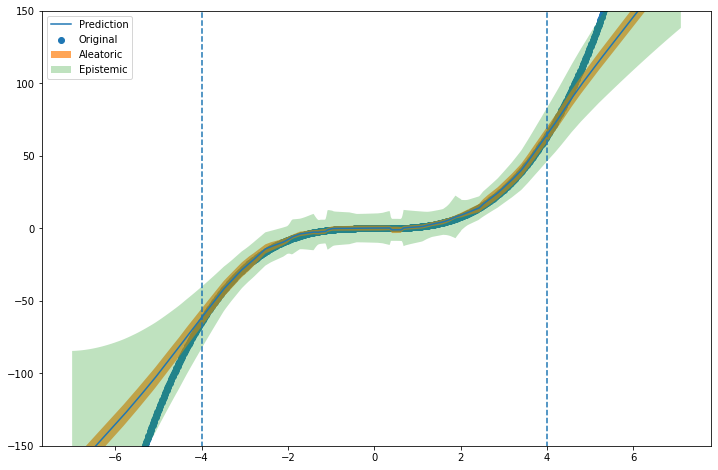

Step 4500:  2.6005  2.5546  4.5936


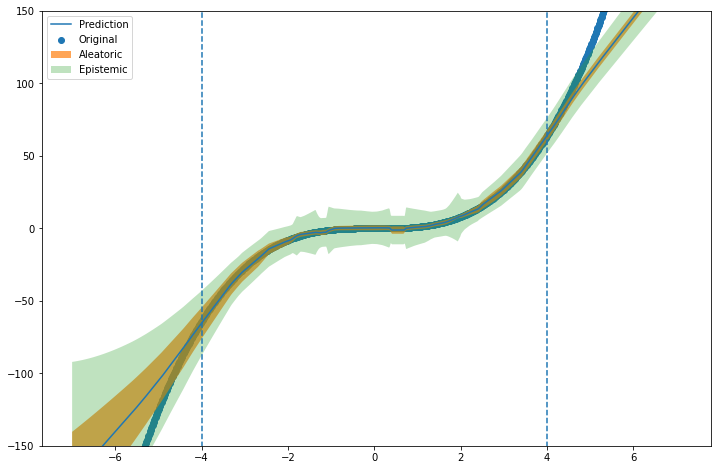

Step 5000:  2.5723  2.5278  4.4523


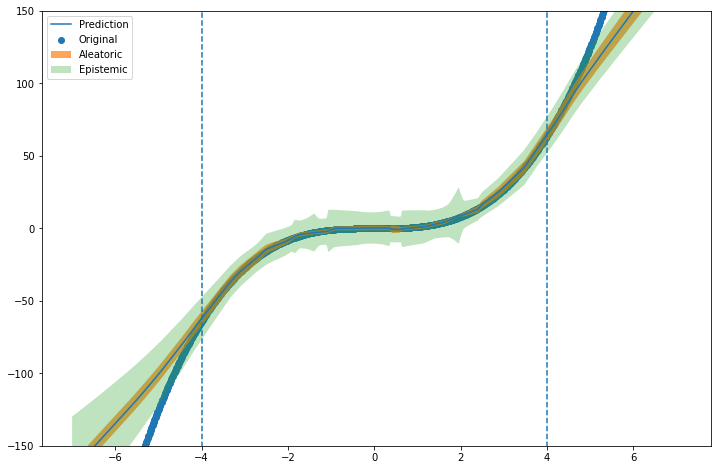

Step 5500:  2.6223  2.5766  4.5786


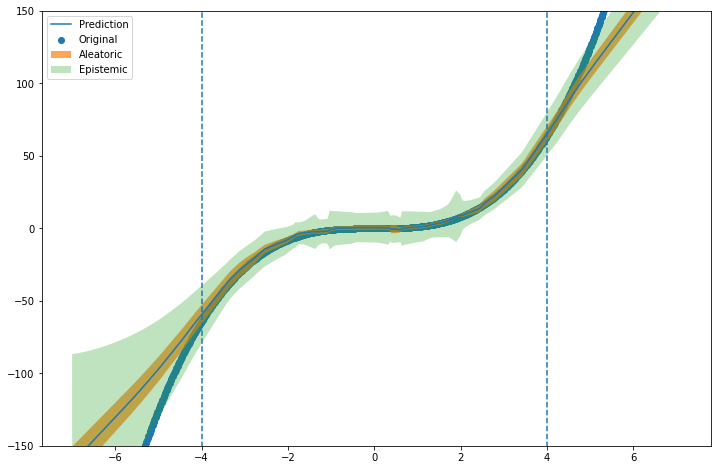

Step 6000:  2.6101  2.5625  4.7670


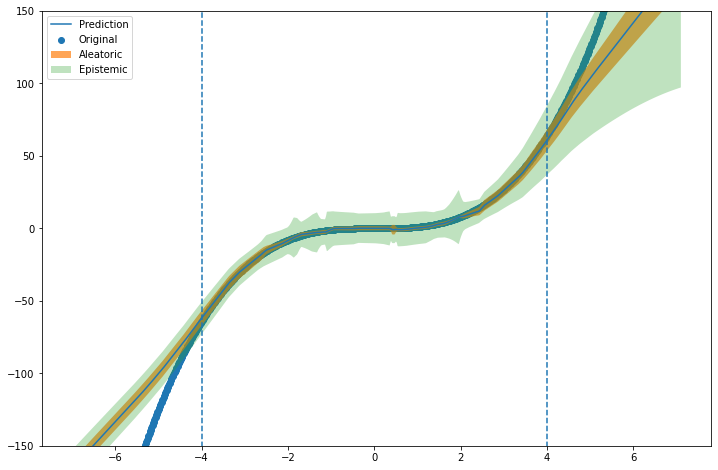

Step 6500:  2.6885  2.6406  4.7928


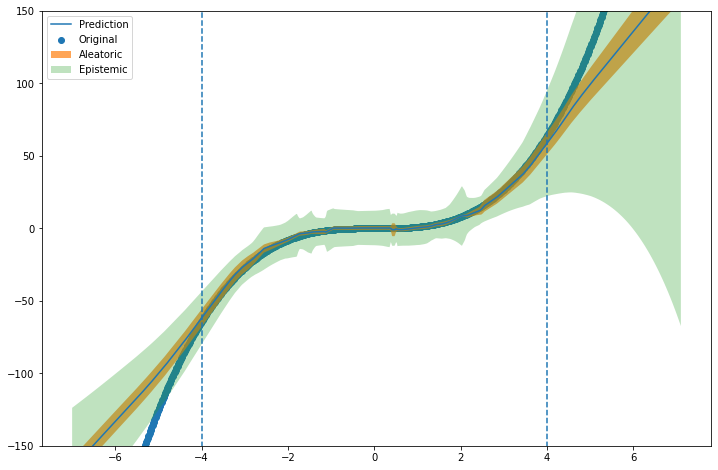

Step 7000:  2.5715  2.5254  4.6215


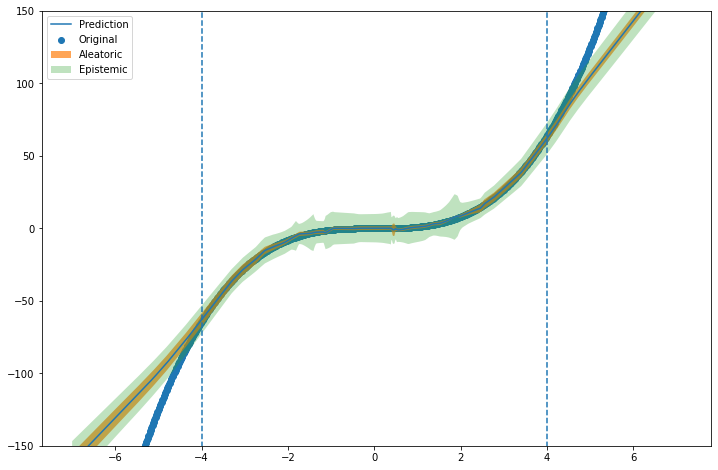

Step 7500:  2.5644  2.5195  4.5004


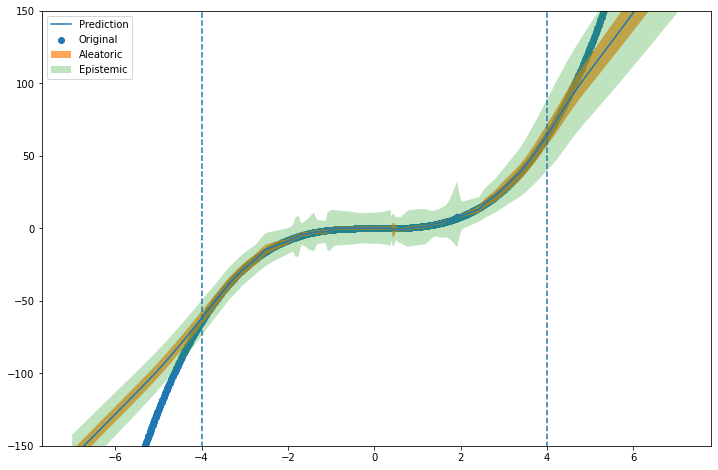

Step 8000:  2.5650  2.5195  4.5599


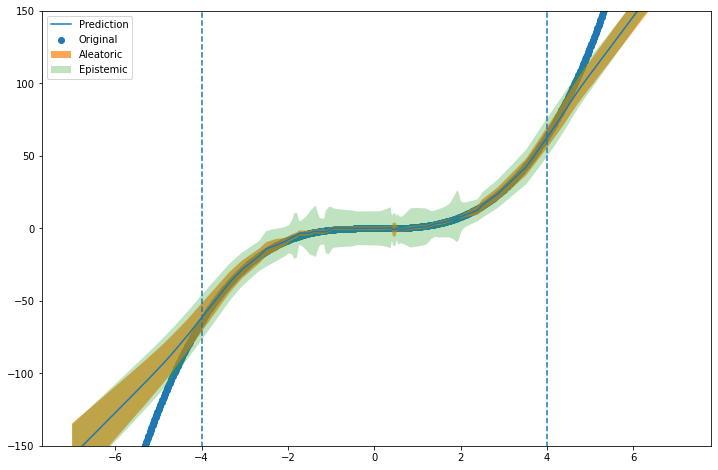

Step 8500:  2.5756  2.5318  4.3916


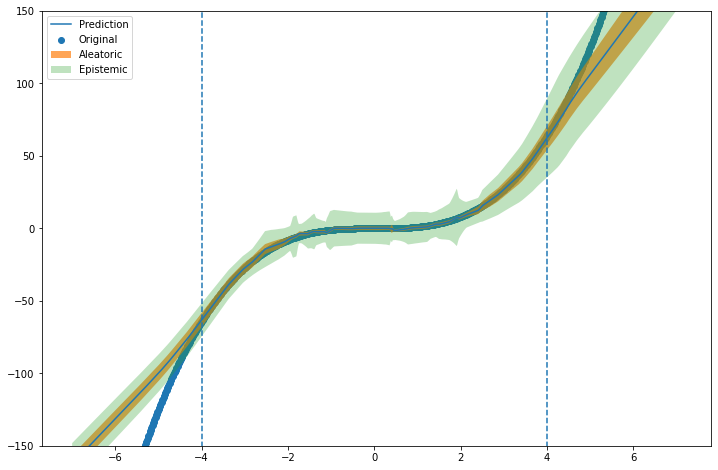

Step 9000:  2.5712  2.5268  4.4433


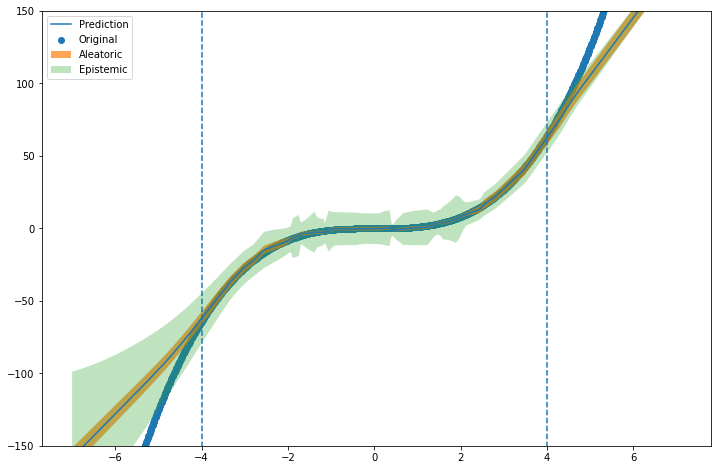

Step 9500:  2.5774  2.5333  4.4214


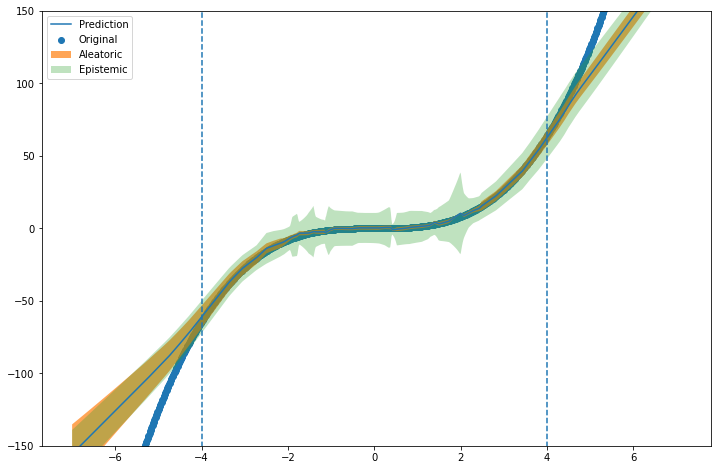

Step 9999:  2.5914  2.5464  4.5049


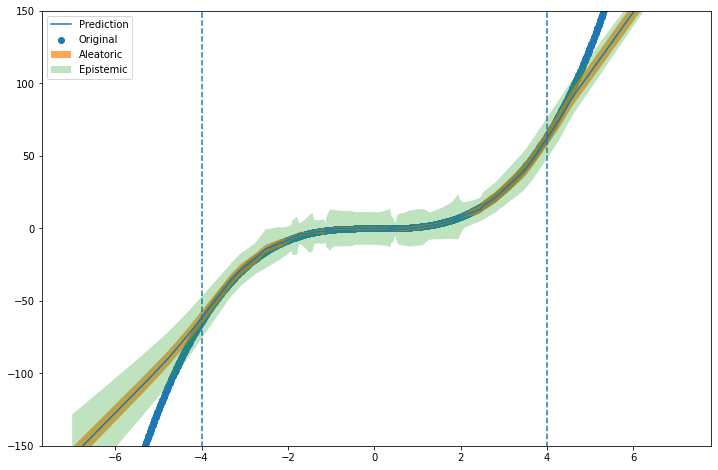

In [5]:
# Training and Plot Prediction

epochs = 10000

model = BasicNetwork()
#pytorch_total_params = sum(p.numel() for p in model.parameters())
#pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
optim = torch.optim.Adam(model.parameters(), lr=5e-3)
#optim = torch.optim.LBFGS(model.parameters(), lr=5e-5)
print("            Loss     NLL     REG")
for epoch in range(epochs):
    Xs, Ys = batching(xs_train, ys, batch_size=128)
    step = 0
    for _xs, _ys in zip(Xs, Ys):
        output = model(_xs)
        (loss, loss_nll, loss_reg) = EvidentialRegression(_ys, output)
        optim.zero_grad()
        loss.backward()
        optim.step()
        step += 1
        if step == 1:
            break
    if epoch%500 == 0 or epoch == (epochs-1):
        out = model(xs_train)
        (_loss, _loss_nll, _loss_reg) = EvidentialRegression(ys, out)
        print("Step {:4d}: {:7.4f} {:7.4f} {:7.4f}".format(epoch, _loss.item(), _loss_nll, _loss_reg))
        if epoch != 0:
            plot()